<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de la red

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

Image name:  ['81_2.bmp']
Label:  ['CytoplasmicReticularAMA']
Image name:  ['665_2.tif']
Label:  ['Negative']
Image name:  ['261_3.tif']
Label:  ['NuclearHomogeneous_CytoplasmicFibrillar']
Image name:  ['942_1.png']
Label:  ['Negative']
Image name:  ['228_2.bmp']
Label:  ['MultipleNuclearDots_CytoplasmicReticularAMA']
Image name:  ['787_1.bmp']
Label:  ['Negative']


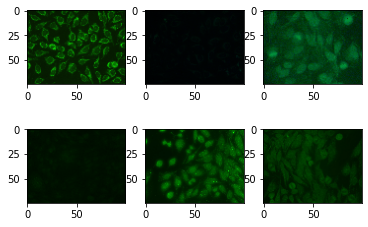

In [3]:
#----------Paths----------

labels_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
images_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/images.npz'

labels = pd.read_csv(labels_path, header = None)
labels = labels.values.tolist()

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

images = np.load(images_path)
images = images['arr_0']

images_list = []
labels_list = []
names_list = []

for i in range(0, 6):
    A = random.randint(0, 2079)
    images_list.append(images[A])
    labels_list.append(labels[A])
    names_list.append(names[A])

for i in range(0,6):
    plt.subplot(2,3, i+1)
    imagen = images_list[i]
    print("Image name: ", names_list[i])
    print("Label: ", labels_list[i])
    plt.imshow(imagen)
plt.show()